In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
root = os.path.join("..","Data")
df = pd.read_excel(os.path.join(root, "DEMAND_FILE_PHASE2.xlsx"))
df = df.iloc[0:2].T.reset_index(drop=True)
df.columns = ['Date','Sales']
df.drop(0, inplace=True)
df['Sales'] = df['Sales'].astype('float')
df['Date'] = pd.to_datetime(df['Date'])
full_date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
df = df.set_index('Date').reindex(full_date_range)
df['Sales'] = df['Sales'].ffill()
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday
train_df = df[df['Date']<"2024-01-01"].reset_index(drop=True)
test_df = df[df['Date'] >= "2024-01-01"].reset_index(drop=True)
    

In [3]:
train_df

,Date,Sales,Month,Weekday
0,2020-04-01,27116.257595,4,2
1,2020-04-02,28710.388430,4,3
2,2020-04-03,30728.165560,4,4
3,2020-04-04,31766.156375,4,5
4,2020-04-05,24258.566380,4,6
...,...,...,...,...
1365,2023-12-27,272767.549675,12,2
1366,2023-12-28,268037.346080,12,3
1367,2023-12-29,268176.608700,12,4
1368,2023-12-30,298067.576955,12,5


In [4]:
root = os.path.join("..","Data")
df = pd.read_csv(os.path.join(root, "Crude Oil Prices.csv"))
df.columns = ['Date','Value']
df['Date'] = pd.to_datetime(df['Date'],format='%d-%m-%y')
df['Value'] = df['Value'].astype('float')

full_date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
df = df.set_index('Date').reindex(full_date_range)
df['Value'] = df['Value'].ffill()
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)
train_prices_df = df[(df['Date']>="2020-04-01") & (df['Date']<"2024-01-01")].reset_index(drop=True)
test_prices_df = df[df['Date'] >= "2024-01-01"].reset_index(drop=True)

In [5]:
train_prices_df

,Date,Value
0,2020-04-01,20.31
1,2020-04-02,25.32
2,2020-04-03,28.34
3,2020-04-04,28.34
4,2020-04-05,28.34
...,...,...
1365,2023-12-27,74.11
1366,2023-12-28,71.77
1367,2023-12-29,71.33
1368,2023-12-30,71.33


In [6]:
def create_sliding_window_sets(sales_df,prices_df, window_size=30):
    sales = sales_df['Sales'].values
    months = sales_df['Month'].values
    weekdays = sales_df['Weekday'].values
    dates = sales_df['Date'].values
    prices = prices_df['Value'].values
    X, Y, X_dates = [], [], []

    for i in range(window_size, len(sales) - window_size):
        x_window = np.concatenate((sales[i - window_size:i],prices[i - window_size:i]))        # previous 30 days
        # x_window = np.concatenate((sales[i - window_size:i],months[i - window_size:i],weekdays[i - window_size:i])) 
        # x_window = sales[i - window_size:i]      # previous 30 days
        y_window = sales[i + 1:i + 1 + window_size] # next 30 days
        today_date = dates[i]                       # today

        X.append(x_window)
        Y.append(y_window)
        X_dates.append(today_date)

    return np.array(X), np.array(Y), np.array(X_dates)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

num_days = 30
X_train, Y_train, dates_train = create_sliding_window_sets(train_df,train_prices_df,num_days)
X_test, Y_test, dates_test = create_sliding_window_sets(test_df,test_prices_df,num_days)

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

def mape(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Avoid division by zero by adding a small epsilon where y_true is zero
    epsilon = tf.keras.backend.epsilon()
    y_true = tf.where(tf.equal(y_true, 0), epsilon, y_true)

    return tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100

# Build FFNN model
model = models.Sequential([
    layers.Input(shape=(2*num_days,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_days) 
])

early_stopping = EarlyStopping(
monitor='mape',
mode = 'min',
patience=15,
restore_best_weights=True )

model.compile(optimizer='adam', loss='mse', metrics=[mape])

# Train the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, verbose=1,callbacks=[early_stopping])


Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20158183424.0000 - mape: 43.1790
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2704216832.0000 - mape: 20.0915
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2562836992.0000 - mape: 19.7949
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2652495104.0000 - mape: 20.5896
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2343492096.0000 - mape: 19.0081
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2653190144.0000 - mape: 19.9085
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2538946304.0000 - mape: 20.2900
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2518518784.0000 - mape: 19.4121
Epoch 9/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2437608960.0000 - mape: 19.5093
Epoch 10/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2482943488.0000 - mape: 19.6629
Epoch 11/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2196918016.0000 - mape: 18.1

In [144]:
Y_pred = model.predict(X_test, verbose=0)

In [145]:
root = os.path.join("..","Data")
df = pd.read_excel(os.path.join(root, "DEMAND_FILE_PHASE2.xlsx"))
df = df.iloc[0:2].T.reset_index(drop=True)
df.columns = ['Date','Sales']
df = df.drop(0).reset_index(drop=True)
df = df.set_index(df['Date'])
df = df.drop(columns=['Date'])
df

c:\Users\milan\Desktop\CDIS Project\.venv\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



,Sales
Date,
2020-04-01,27116.257595
2020-04-02,28710.38843
2020-04-03,30728.16556
2020-04-04,31766.156375
2020-04-05,24258.56638
...,...
2024-12-27,267775
2024-12-28,274362
2024-12-29,244200


In [146]:
makar_sankranti_dates = pd.to_datetime([
    '2020-01-14',
    '2021-01-14',
    '2022-01-14',
    '2023-01-14',
    '2024-01-14'
])

holi_dates = pd.to_datetime([
    '2020-03-10',
    '2021-03-29',
    '2022-03-18',
    '2023-03-08',
    '2024-03-25'
])

rakshabandhan_dates = pd.to_datetime([
    '2020-08-03',
    '2021-08-22',
    '2022-08-11',
    '2023-08-30',
    '2024-08-19'
])

janmashtami_dates = pd.to_datetime([
    '2020-08-12',
    '2021-08-30',
    '2022-08-19',
    '2023-09-07',
    '2024-08-26'
])

dussehra_dates = pd.to_datetime([
    '2020-10-25',
    '2021-10-15',
    '2022-10-05',
    '2023-10-24',
    '2024-10-12'
])

diwali_dates = pd.to_datetime([
    '2020-11-14',
    '2021-11-04',
    '2022-10-24',
    '2023-11-12',
    '2024-10-31'
])
diwali_prev2_dates = diwali_dates - pd.Timedelta(days=2)
diwali_prev1_dates = diwali_dates - pd.Timedelta(days=1)
diwali_next1_dates = diwali_dates + pd.Timedelta(days=1)
diwali_next2_dates = diwali_dates + pd.Timedelta(days=2)
diwali_next3_dates = diwali_dates + pd.Timedelta(days=3)
diwali_next4_dates = diwali_dates + pd.Timedelta(days=4)
diwali_next5_dates = diwali_dates + pd.Timedelta(days=5)
diwali_next6_dates = diwali_dates + pd.Timedelta(days=6)

def average_decrease(df, date_list):
    decreases = []
    for date in date_list[:-1]:
        if date in df.index and (date - pd.Timedelta(days=1)) in df.index:
            today_sales = df.loc[date, 'Sales']
            prev_day_sales = df.loc[date - pd.Timedelta(days=1), 'Sales']
            decrease = prev_day_sales - today_sales
            percentage_deacrease = (decrease/prev_day_sales)*100
            decreases.append(percentage_deacrease)
    return sum(decreases) / len(decreases) if decreases else None


avg_decrease_holi = average_decrease(df, holi_dates)
avg_decrease_makar = average_decrease(df, makar_sankranti_dates)
avg_decrease_raksha = average_decrease(df, rakshabandhan_dates)
avg_decrease_janmashtami = average_decrease(df, janmashtami_dates)
avg_decrease_dussehra = average_decrease(df, dussehra_dates)
avg_decrease_diwali = average_decrease(df, diwali_dates)
avg_decrease_diwali_prev1 = average_decrease(df, diwali_prev1_dates)
avg_decrease_diwali_prev2 = average_decrease(df, diwali_prev2_dates)
avg_decrease_diwali_next1 = average_decrease(df, diwali_next1_dates)
avg_decrease_diwali_next2 = average_decrease(df, diwali_next2_dates)
avg_decrease_diwali_next3 = average_decrease(df, diwali_next3_dates)
avg_decrease_diwali_next4 = average_decrease(df, diwali_next4_dates)
avg_decrease_diwali_next5 = average_decrease(df, diwali_next5_dates)
avg_decrease_diwali_next6 = average_decrease(df, diwali_next6_dates)


In [147]:
def correct_holidays(dates_test,holiday_dates,Y_pred, avg_decrease):
    start_date = dates_test[0]
    target_date = holiday_dates[-1]
    date_range = pd.date_range(start=target_date - pd.Timedelta(days=30), 
                            end=target_date - pd.Timedelta(days=1))

    for date in date_range:
        i = (pd.to_datetime(date) - pd.to_datetime(start_date)).days
        j = (pd.to_datetime(target_date) - pd.to_datetime(date)).days
        Y_pred[i][j-1] = Y_pred[i][j-2]*(1-avg_decrease/100)

    return Y_pred

Y_pred = correct_holidays(dates_test,holi_dates,Y_pred, avg_decrease_holi)
Y_pred = correct_holidays(dates_test,rakshabandhan_dates,Y_pred, avg_decrease_raksha)
Y_pred = correct_holidays(dates_test,janmashtami_dates,Y_pred, avg_decrease_janmashtami)
Y_pred = correct_holidays(dates_test,dussehra_dates,Y_pred, avg_decrease_dussehra)
Y_pred = correct_holidays(dates_test,diwali_prev2_dates,Y_pred, avg_decrease_diwali_prev2)
Y_pred = correct_holidays(dates_test,diwali_prev1_dates,Y_pred, avg_decrease_diwali_prev1)
Y_pred = correct_holidays(dates_test,diwali_dates,Y_pred, avg_decrease_diwali)
Y_pred = correct_holidays(dates_test,diwali_next1_dates,Y_pred, avg_decrease_diwali_next1)
Y_pred = correct_holidays(dates_test,diwali_next2_dates,Y_pred, avg_decrease_diwali_next2)
Y_pred = correct_holidays(dates_test,diwali_next3_dates,Y_pred, avg_decrease_diwali_next3)
Y_pred = correct_holidays(dates_test,diwali_next4_dates,Y_pred, avg_decrease_diwali_next4)
Y_pred = correct_holidays(dates_test,diwali_next5_dates,Y_pred, avg_decrease_diwali_next5)
Y_pred = correct_holidays(dates_test,diwali_next6_dates,Y_pred, avg_decrease_diwali_next6)

In [165]:
import plotly.graph_objects as go

start_date = dates_test[0]
date = '2024-09-04' # can go upto 2024-12-01
i = (pd.to_datetime(date) - pd.to_datetime(start_date)).days

x = pd.date_range(start=pd.to_datetime(date) + pd.Timedelta(days=1), periods=30)
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=Y_pred[i], mode='lines+markers', name=f'Prediction'))
fig.add_trace(go.Scatter(x=x, y=Y_test[i], mode='lines+markers', name=f'True values'))
fig.update_layout(title=f'Prediction at {date}. Mape = {mape(Y_pred[i],Y_test[i])}', legend_title='Legend')
fig.show()

In [149]:
import plotly.graph_objects as go

mapes=[]
for i in range(len(Y_pred)):
    mapes.append(mape(Y_pred[i],Y_test[i]))
mapes=np.array(mapes)
print("The mean MAPE is :",mapes.mean())
print("The median MAPE is : ", np.median(mapes))

fig = go.Figure(data=[go.Histogram(x=mapes, nbinsx=50)])
fig.update_layout(title=f'Histogram of Average MAPE. Average MAPE = {mapes.mean()}', xaxis_title='Daily MAPE', yaxis_title='Count')
fig.show()

The mean MAPE is : 8.764597
The median MAPE is :  7.706548


In [150]:
total = len(mapes)

# Calculate percentages for each bin
pct_0_5 = np.sum((mapes > 0) & (mapes <= 5)) / total * 100
pct_5_10 = np.sum((mapes > 5) & (mapes <= 10)) / total * 100
pct_10_15 = np.sum((mapes > 10) & (mapes <= 15)) / total * 100
pct_15_20 = np.sum((mapes > 15) & (mapes <= 20)) / total * 100
pct_above_20 = np.sum(mapes > 20) / total * 100
print(f"0–5: {pct_0_5:.2f}%")
print(f"5–10: {pct_5_10:.2f}%")
print(f"10–15: {pct_10_15:.2f}%")
print(f"15–20: {pct_15_20:.2f}%")
print(f">20: {pct_above_20:.2f}%")

0–5: 13.40%
5–10: 56.86%
10–15: 21.24%
15–20: 5.88%
>20: 2.61%


In [151]:
import plotly.graph_objects as go

dates = pd.date_range(start=dates_test[0], periods=len(X_test))
mape_df = pd.DataFrame({'Date':dates,'Mape': mapes})

fig = go.Figure()
fig.add_trace(go.Line(x = mape_df['Date'],
                    y = mape_df['Mape'],
                    mode = 'lines+markers',
                    name = 'Average MAPE'))

fig.update_layout(xaxis_title = 'Date', yaxis_title = 'MAPE', title = 'MAPE vs Date')
fig.show()

c:\Users\milan\Desktop\CDIS Project\.venv\Lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [152]:
import pandas as pd
import plotly.express as px

# Ensure 'Date' column is in datetime format
mape_df['Date'] = pd.to_datetime(mape_df['Date'])

# Create a 'Week' column (ISO year-week format)
mape_df['Week'] = mape_df['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Group by week and compute mean MAPE
weekly_mean_mape = mape_df.groupby('Week')['Mape'].mean().reset_index()

# (Optional) Round MAPE values to 2 decimal places
weekly_mean_mape['Mape'] = weekly_mean_mape['Mape'].round(2)

fig = px.line(weekly_mean_mape,x='Week',y='Mape')
fig.update_layout(xaxis_title = 'Week', yaxis_title = 'MAPE(%)', title ='Weekly Trend of MAPE')
fig.show()


In [153]:
weekly_mapes = weekly_mean_mape['Mape'].values
total = len(weekly_mapes)

# Calculate percentages for each bin
pct_0_5 = np.sum((weekly_mapes > 0) & (weekly_mapes <= 5)) / total * 100
pct_5_10 = np.sum((weekly_mapes > 5) & (weekly_mapes <= 10)) / total * 100
pct_10_15 = np.sum((weekly_mapes > 10) & (weekly_mapes <= 15)) / total * 100
pct_15_20 = np.sum((weekly_mapes > 15) & (weekly_mapes <= 20)) / total * 100
pct_above_20 = np.sum(weekly_mapes > 20) / total * 100
print(f"0–5: {pct_0_5:.2f}%")
print(f"5–10: {pct_5_10:.2f}%")
print(f"10–15: {pct_10_15:.2f}%")
print(f"15–20: {pct_15_20:.2f}%")
print(f">20: {pct_above_20:.2f}%")

0–5: 9.09%
5–10: 56.82%
10–15: 29.55%
15–20: 4.55%
>20: 0.00%


In [154]:
mape_df['YearMonth'] = mape_df['Date'].dt.to_period('M')  # or use dt.to_period('M') to preserve month-year format

# Group by month and compute mean MAPE
monthly_mean_mape = mape_df.groupby('YearMonth')['Mape'].mean().reset_index()

# Optional: Convert Period back to string or datetime if needed
monthly_mean_mape['YearMonth'] = monthly_mean_mape['YearMonth'].astype(str)

monthly_mean_mape = monthly_mean_mape.drop(0)
monthly_mean_mape = monthly_mean_mape.drop(11).reset_index(drop=True)
monthly_mean_mape['YearMonth'] = pd.to_datetime(monthly_mean_mape['YearMonth']).dt.strftime('%B')
monthly_mean_mape['Mape'] = monthly_mean_mape['Mape'].round(2)
monthly_mean_mape

,YearMonth,Mape
0,February,6.97
1,March,11.16
2,April,9.26
3,May,6.10
4,June,4.75
5,July,5.88
6,August,11.66
7,September,9.53
8,October,12.11
9,November,10.27


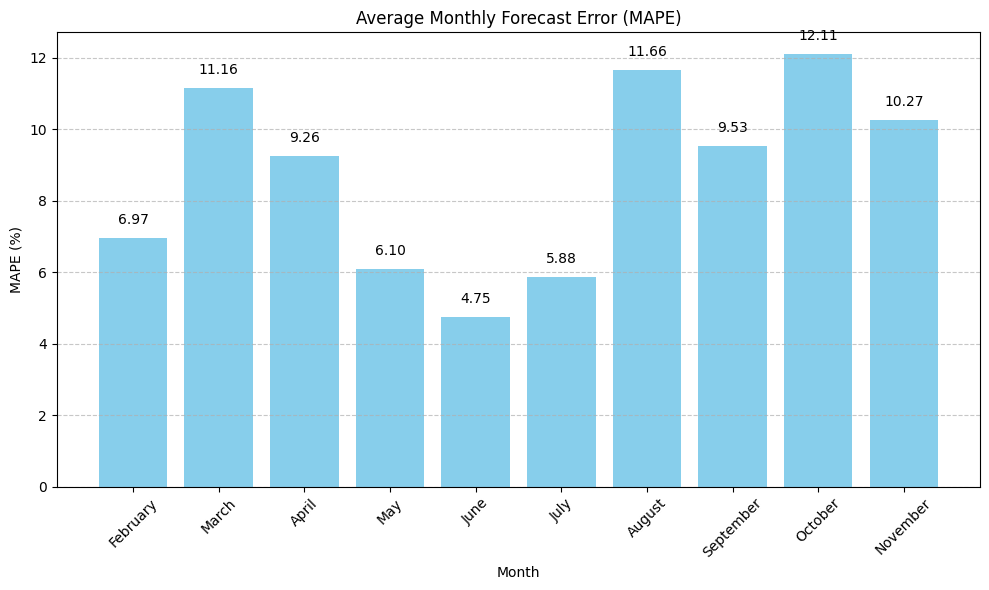

In [155]:
import matplotlib.pyplot as plt

# Plotting with value labels
plt.figure(figsize=(10, 6))
bars = plt.bar(monthly_mean_mape['YearMonth'], monthly_mean_mape['Mape'], color='skyblue')
plt.xlabel("Month")
plt.ylabel("MAPE (%)")
plt.title("Average Monthly Forecast Error (MAPE)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.3, f'{yval:.2f}', ha='center', va='bottom')

plt.show()


In [156]:
root = os.path.join("..","Data")
df = pd.read_excel(os.path.join(root, "DEMAND_FILE_PHASE2.xlsx"))
df = df.iloc[0:2].T.reset_index(drop=True)
df.columns = ['Date','Sales']
df = df.drop(0).reset_index(drop=True)
df = df.set_index(df['Date'])
df = df.drop(columns=['Date'])
df

c:\Users\milan\Desktop\CDIS Project\.venv\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



,Sales
Date,
2020-04-01,27116.257595
2020-04-02,28710.38843
2020-04-03,30728.16556
2020-04-04,31766.156375
2020-04-05,24258.56638
...,...
2024-12-27,267775
2024-12-28,274362
2024-12-29,244200


In [157]:
import plotly.express as px

fig = px.line(df,x=df.index,y='Sales')
fig.show()